**CRNN Model**

Index(['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20', 'LABEL'],
      dtype='object')
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6847 - loss: 0.5791 - val_accuracy: 0.8192 - val_loss: 0.3974
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8426 - loss: 0.3504 - val_accuracy: 0.8701 - val_loss: 0.3022
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8790 - loss: 0.2998 - val_accuracy: 0.9172 - val_loss: 0.2149
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9081 - loss: 0.2433 - val_accuracy: 0.9435 - val_loss: 0.1567
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9326 - loss: 0.1818 - val_accuracy: 0.9351 - val_loss: 0.1704
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9459 - loss: 0.1433 - val_accuracy: 0.9533 - val_loss: 0.1180
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9551 - loss: 0.1293 - val_accuracy: 0.9614 - val_loss: 0.0997
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9582 - loss: 0.1089 - val_accuracy: 0.970

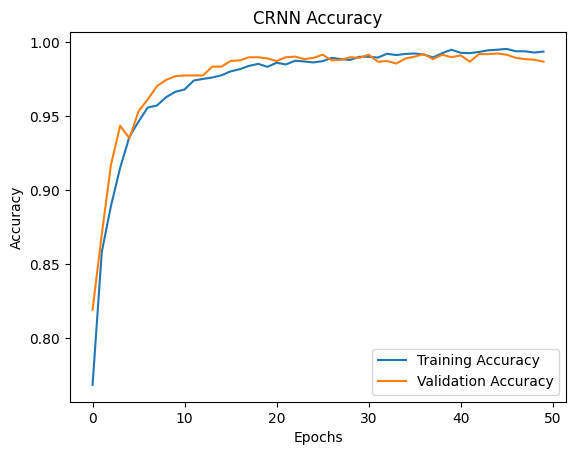

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      1193
        REAL       0.98      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



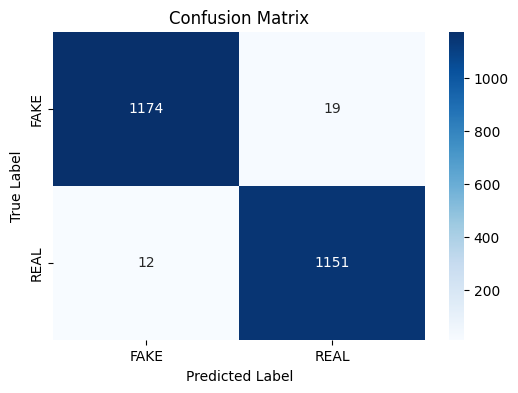

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset (replace this with actual path)
# Ensure that your dataset is in the format you provided with MFCCs and labels
audio_data = pd.read_csv('/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv')

# Print column names to verify
print(audio_data.columns)

# Feature Extraction (Assuming MFCC and other relevant features are already in the dataset)
X = audio_data.drop(columns=['LABEL']).values  # All features except the label
y = audio_data['LABEL'].values  # Labels

# Convert categorical labels ('Fake' and 'Real') to numeric labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'Fake' -> 0, 'Real' -> 1

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for Conv1D (samples, timesteps, features)
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

# Define CRNN model
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Recurrent layers (LSTM)
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=50, validation_data=(X_test_scaled, y_test))

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CRNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save the model
model.save('deepfake_detection_emotion_crnn.h5')


In [21]:
print(audio_data.columns)

Index(['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20', 'LABEL'],
      dtype='object')


**WIRENET (Bidirectional LSTM )**

In [22]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)
from sklearn.metrics import confusion_matrix
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [23]:
X_train,X_Test,Y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape[1]

26

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_Test)

X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

In [25]:
def WIRENetSpoofImprovedEnhanced(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(256, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)  # Increased dropout rate for regularization

    x = Conv1D(512, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(256, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)

    x = Conv1D(512, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (X_train_std.shape[1], 1)


def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.1
    return lr


model = WIRENetSpoofImprovedEnhanced(input_shape)

model.compile(
    optimizer=Adam(learning_rate=0.000001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    X_train_std,
    Y_train,
    epochs=100,
    batch_size=32)

Epoch 1/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.5166 - loss: 4.2394
Epoch 2/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.5649 - loss: 4.1629
Epoch 3/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.5908 - loss: 4.1159
Epoch 4/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6115 - loss: 4.0788
Epoch 5/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6511 - loss: 4.0153
Epoch 6/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.6639 - loss: 3.9920
Epoch 7/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6816 - loss: 3.9695
Epoch 8/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6956 - loss: 3.9379
Epoch 9/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6959 - loss: 3.9311
Epoch 10/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.7024 - loss: 3.9055
Epoch 11/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7263 - loss: 3.8607
Epoch 12/100
295/29

In [26]:
test_loss, test_acc = model.evaluate(X_test_std, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9725 - loss: 2.2507
Test Loss: 2.2430336475372314
Test Accuracy: 0.9766553640365601


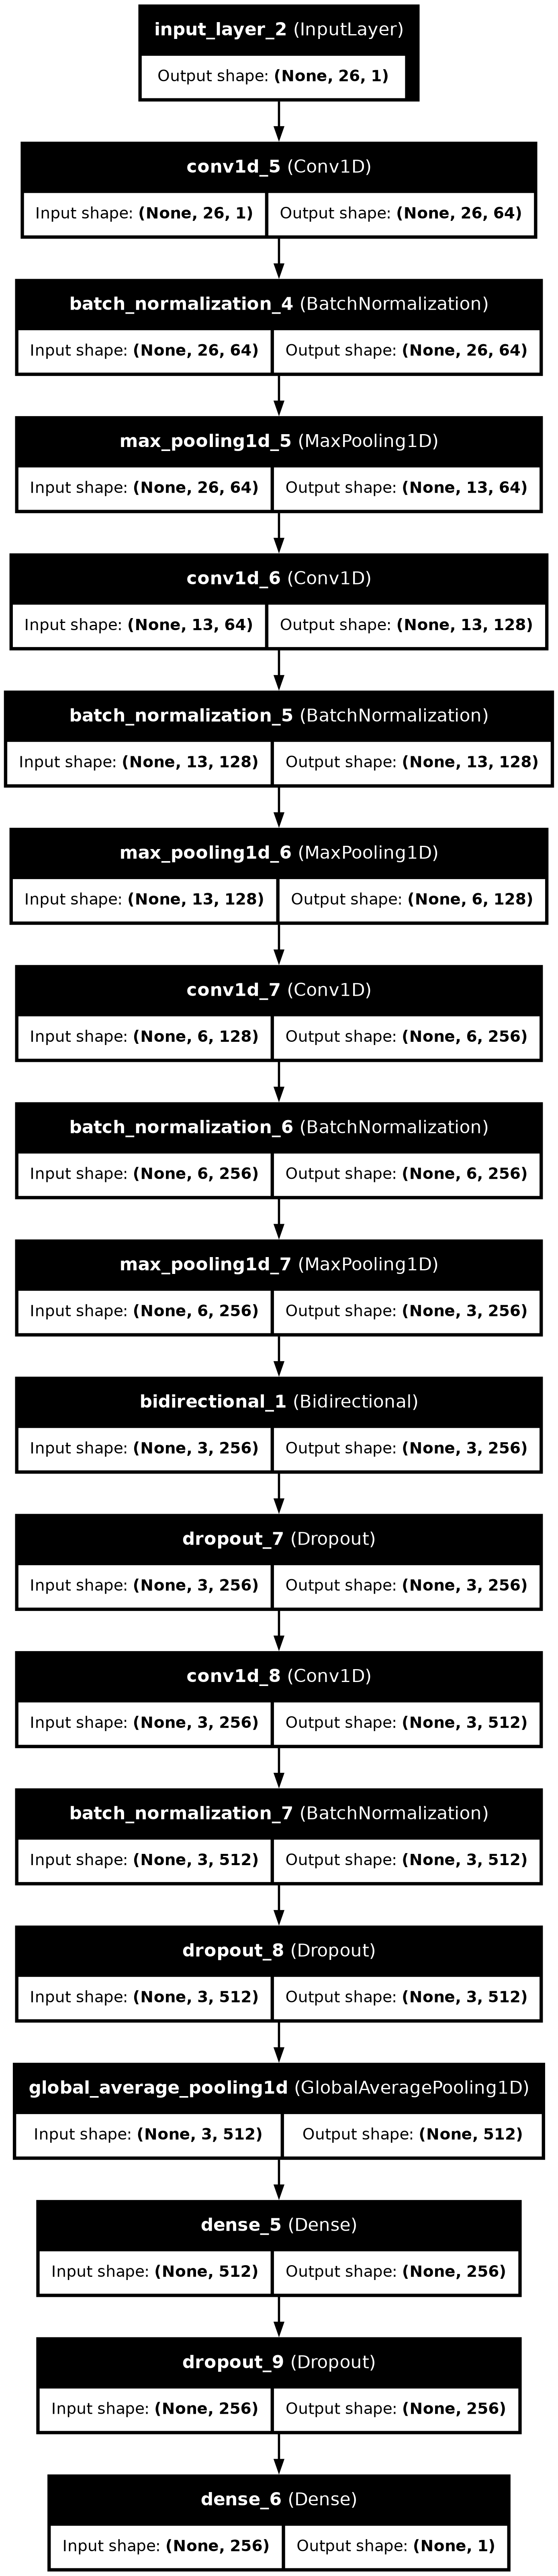

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='wirenet_architecture.png', show_shapes=True, show_layer_names=True)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      1178
        Real       0.98      0.98      0.98      1178

    accuracy                           0.98      2356
   macro avg       0.98      0.98      0.98      2356
weighted avg       0.98      0.98      0.98      2356



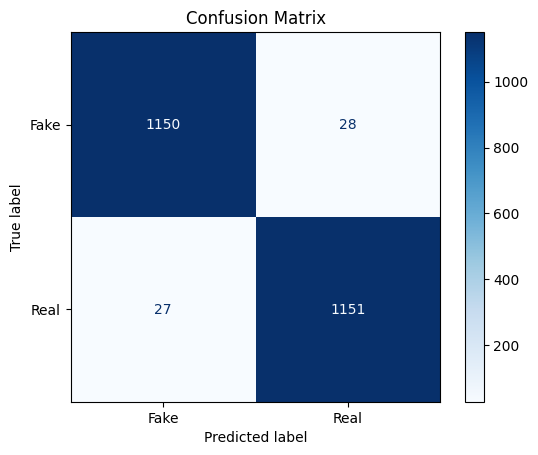

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = model.predict(X_test_std)

# Convert predictions to binary format (threshold at 0.5)
y_pred = (y_pred > 0.5).astype(int)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Fake', 'Real'])
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


**FCNN Model**

   chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.338055  0.027948        2842.948867         4322.916759  6570.586186   
1     0.443766  0.037838        2336.129597         3445.777044  3764.949874   
2     0.302528  0.056578        2692.988386         2861.133180  4716.610271   
3     0.319933  0.031504        2241.665382         3503.766175  3798.641521   
4     0.420055  0.016158        2526.069123         3102.659519  5025.077899   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.041050 -462.169586   90.311272  19.073769  24.046888  ...   
1            0.047730 -409.413422  120.348808  -7.161531   5.114784  ...   
2            0.080342 -318.996033  120.490273 -24.625771  23.891073  ...   
3            0.047180 -404.636749  136.320908   2.308172  -3.907071  ...   
4            0.051905 -410.497925  152.731400 -18.266771  51.993462  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17 

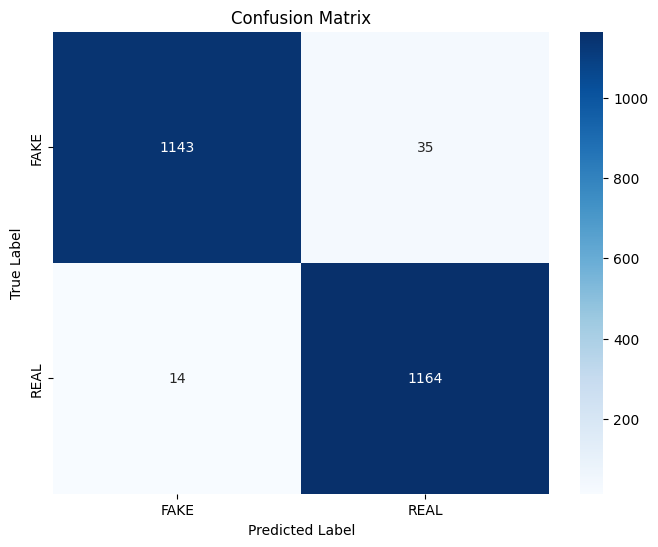

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Load the dataset
data_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv"
audio_data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(audio_data.head())

# Encode the labels as numeric values
label_encoder = LabelEncoder()
audio_data['LABEL'] = label_encoder.fit_transform(audio_data['LABEL'])

# Define features and labels
X = audio_data.drop('LABEL', axis=1).values  # Adjust this if the label column is named differently
y = audio_data['LABEL'].values

# Check the datatype of the labels
print(f"Labels data type: {y.dtype}")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make sure y is the correct shape
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model, define loss function and optimizer
model = SimpleNN(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = (test_outputs > 0.5).float()

# Classification report
print(classification_report(y_test_tensor.numpy(), test_predictions.numpy()))

# Confusion matrix
cm = confusion_matrix(y_test_tensor.numpy(), test_predictions.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
